In [ ]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd
from azureml.core.authentication import InteractiveLoginAuthentication

p = ESMLProject() # Your project settings - knows Azure services, networking, lakedesign, identity mgmt, security, etc
p.inference_mode = False

auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
#auth = InteractiveLoginAuthentication(force=True, tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)

p.active_model = 11
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.connect_to_lake()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)


In [ ]:
import sys
sys.path.insert(0, "../2_A_aml_pipeline/4_inference/batch/M11/")

from esmlrt.interfaces.iESMLController import IESMLController
from esmlrt.interfaces.iESMLModelCompare import IESMLModelCompare
from esmlrt.interfaces.iESMLTestScoringFactory import IESMLTestScoringFactory
from esmlrt.interfaces.iESMLTrainer import IESMLTrainer

from esmlrt.runtime.ESMLController import ESMLController
from esmlrt.runtime.ESMLModelCompare2 import ESMLModelCompare
from esmlrt.runtime.ESMLTestScoringFactory2 import ESMLTestScoringFactory
from your_code.your_train_code import Trainer

In [ ]:
ws = p.ws
target_column_name = p.active_model["label"]
ml_type = p.active_model["ml_type"]
esml_modelname = p.model_folder_name
esml_model_alias = p.ModelAlias
esml_current_env  = p.dev_test_prod
train_ds = p.GoldTrain
validate_ds = p.GoldValidate
test_ds = p.GoldTest

secret_name_tenant = "kv-msft-weu-dev-cmnai-tenant"
secret_name_sp_id = "kv-secret-esml-project002-sp-id"
secret_name_sp_secret = "kv-secret-esml-project002-sp-secret"

test_scoring = ESMLTestScoringFactory(ml_type) # You need to implement IESMLTestScoringFactory
comparer = ESMLModelCompare(setting_path = "") # You need to implement IESMLModelCompare

controller = ESMLController(comparer,test_scoring,"project002",esml_modelname, esml_model_alias, secret_name_tenant,secret_name_sp_id,secret_name_sp_secret ) # IESMLController: you do not have to change/implemen this class. Dependency injects default or your class.
controller.dev_test_prod = esml_current_env
controller.version()

...


In [8]:
controller.experiment_name

'11_diabetes_model_reg'

In [9]:
from azureml.train.automl.run import AutoMLRun

automl_step_run_id = '8b7c996f-6937-4470-a42b-7e59d91f6d49'

experiment_run = ws.experiments[controller.experiment_name] # Get the experiment. Alternatively: Experiment(workspace=source_workspace, name=experiment_name)
automl_step_run = AutoMLRun(experiment_run, run_id = automl_step_run_id)
best_run, fitted_model_1 = automl_step_run.get_output()

promote_new_model,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = comparer.compare_scoring_current_vs_new_model(
    new_run_id = automl_step_run_id, # main_run.id,
    current_ws = ws,
    current_environment = esml_current_env,
    target_environment = esml_current_env,
    target_workspace = ws,
    experiment_name = controller.experiment_name)

source_best_run.properties['model_name'] is: 8b7c996f69374470
TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
TIME: Model list LAMBDA FILTER, on experiment_name 11_diabetes_model_reg
TIME: FILTER ModelList:
Minutes: 3.801051127910614
target_best_run_id fe8a33f4-5650-4650-9947-240e338b1650
New trained model & cached RUN, has TASK_TYPE: regression and Best_Run_id: 8b7c996f-6937-4470-a42b-7e59d91f6d49_0
Target model & RUN, in Azure ML Studio workspace to compare with, has TASK_TYPE: regression and Best_Run_id:8b7c996f-6937-4470-a42b-7e59d91f6d49_0 

Q: Do we have SCORING DRIFT / CONCEPT DRIFT? - Is a model trained on NEW data better? = the one in production degraded?

New trained model: model id 11_diabetes_model_reg:13
INFO: Using ESML TEST_SET SCORING, since tagged on MODEL - using this to compare SCORING
RMSE (normalized_root_mean_squared_error): 56.501912
MAPE (Mean average Percentage Error): 0.339886
MAE (normalized_mean_absolute_e

In [9]:
print(IESMLController.esml_status_new)

esml_newly_trained


In [10]:
controller.dev_test_prod

'dev'

# Get BEST MODEL

In [10]:
experiment, model,main_run, best_automl_run,fitted_model = controller.get_latest_run_via_PipelineMetaDataset(ws,controller.experiment_name, controller.dataset_gold_train_runinfo_name_azure)
print("     ###    ")
print("Experiment:", experiment.name)
print("Pipeline RUN:", main_run.id)
print("Best RUN:",best_automl_run)
print ("...and...")

print("AML Model()", type(model))
print("Fitted model", type(fitted_model))

     ###    
Experiment: 11_diabetes_model_reg
Pipeline RUN: 67eb1b80-b1b3-4c63-a33e-f94c523fb157
Best RUN: None
...and...
AML Model() <class 'NoneType'>
Fitted model <class 'NoneType'>


In [11]:
main_run

Experiment,Id,Type,Status,Details Page,Docs Page
11_diabetes_model_reg,67eb1b80-b1b3-4c63-a33e-f94c523fb157,azureml.PipelineRun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [11]:
experiment, model,main_run, best_run,fitted_model = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name)
print(experiment.name)
print(model.name)
print(main_run.id)
try:
    print(model.tags['esml_time_updated'])
except:
    print("Not an ESML registered model..")
    
print ("...and...")
print(type(best_run))
print(type(fitted_model))

11_diabetes_model_reg
AutoML7e64144860
AutoML_7e641448-6917-4096-a793-186b3090d58f
09/02/2022, 23:30:26
...and...
<class 'azureml.core.run.Run'>
<class 'azureml.automl.runtime.shared.model_wrappers.RegressionPipeline'>


In [11]:
experiment, model,main_run, best_run,fitted_model = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name)
print(experiment.name)
print(model.name)
print(main_run.id)
try:
    print(model.tags['esml_time_updated'])
except:
    print("Not an ESML registered model..")
    
print ("...and...")
print(type(best_run))
print(type(fitted_model))

Searching model - LOOPING the experiment to match name (1st time thing, since no tags)
Could not find tags, run_id or model_name on latest_model


AttributeError: 'NoneType' object has no attribute 'name'

In [ ]:
model_highest_version, run_id_tag, model_name_tag = IESMLController.get_best_model_via_modeltags_only_DevTestProd(ws,controller.experiment_name,filter_on_version=None,sort_by_created_instead_of_version=False) # 3:39 LAMBDA
print(model_highest_version.name)
print(run_id_tag)
print(model_name_tag)
# 4.24 Datetime sort
try:
    print(model_highest_version.version) # AutoML00b58dfed0 (v17) (manual run) VS 11_diabetes_model_reg(v 11) -> Both are TAGGED with experiment_name=11_diabetes_model_reg
    print(model_highest_version.created_time)
    print(model_highest_version.tags['esml_time_updated'])
except:
    print("Not an ESML registered model..")

print("model_highest_version.run is None: {}".format((model_highest_version.run is None)))

TIME: Model list LAMBDA FILTER, on experiment_name 11_diabetes_model_reg
TIME: FILTER ModelList:
Minutes: 4.0634996096293134
AutoML00b58dfed0
AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af
AutoML00b58dfed0
17
2022-08-17 15:33:03.977037+00:00
Not an ESML registered model..
model_highest_version.run is None: False


In [ ]:
from azureml.core import Model
all_models = Model.list(workspace=ws)
filtered_list = list(filter(lambda r: (r.tags.get("experiment_name") == controller.experiment_name), all_models))

filtered_list.sort(key=lambda r: r.version,reverse=True)
            
if (len(filtered_list) > 0): # IF we found any...
    model_highest_version = filtered_list[0]

print(model_highest_version.version)
print(model_highest_version.created_time)

17
{'userObjectId': 'cf4dc094-c020-47f5-b76f-d8de4d17f44c', 'userIdp': 'https://sts.windows.net/72f988bf-86f1-41af-91ab-2d7cd011db47/', 'userIss': 'https://sts.windows.net/72f988bf-86f1-41af-91ab-2d7cd011db47/', 'userTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47', 'userName': '9b8fdad2-fbeb-488e-b0b9-40dfe5a1ea5e'}


In [17]:
print(model_highest_version.created_time)

2022-08-17 15:33:03.977037+00:00


# get TEST SCORING

In [17]:
#  label,ws, GoldTest, model, fitted_model, source_best_run/run
experiment, model,main_run, best_automl_run,fitted_model = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name)

<class 'azureml.train.automl.run.AutoMLRun'>


In [18]:
best_automl_run.properties['model_name']

'AutoML00b58dfed0'

In [19]:
type(fitted_model)

azureml.automl.runtime.shared.model_wrappers.RegressionPipeline

Replacing tag run_id -> AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af with run_id -> AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af
Replacing tag model_name -> AutoML00b58dfed0 with model_name -> AutoML00b58dfed0
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag test_set_RMSE -> 57.085702 with test_set_RMSE -> 57.085702
Replacing tag test_set_R2 -> 0.321046 with test_set_R2 -> 0.321046
Replacing tag test_set_MAPE -> 0.272820 with test_set_MAPE -> 0.272820
Replacing tag test_set_Spearman_Correlation -> 0.593598 with test_set_Spearman_Correlation -> 0.593598
Replacing tag esml_time_updated -> 08/17/2022, 17:30:56 with esml_time_updated -> 08/17/2022, 17:30:56
Model tag add operation complete.


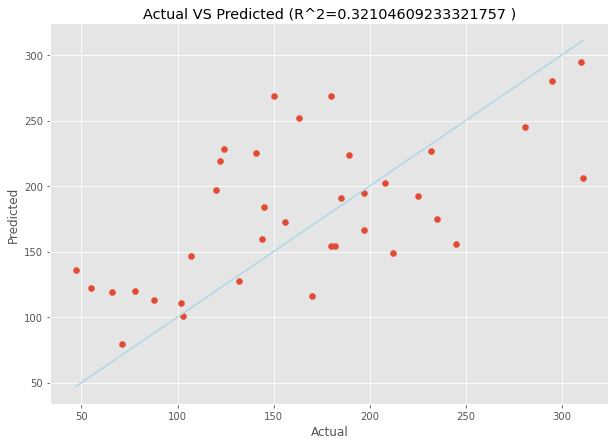

In [20]:
rmse, r2, mean_abs_percent_error,mae,spearman_correlation,plt, dummy = test_scoring.get_test_scoring_8(ws,target_column_name,test_ds,fitted_model,best_automl_run,model)

# REGISTER model in DEV

In [21]:
experiment, model2,main_run, best_automl_run,fitted_model = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name) # Get model again

<class 'azureml.train.automl.run.AutoMLRun'>


In [22]:
model_registered_in_target = controller.register_model(source_ws=ws, target_env="dev", source_model_to_copy_tags_from=model2)

Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
<class 'azureml.train.automl.run.AutoMLRun'>
model.version 16
Model name AutoML00b58dfed0 is registered.


# REGISTER model from DEV to TEST

In [23]:
model_registered_in_target = controller.register_model(source_ws=ws, target_env="test", source_model_to_copy_tags_from=model2)

Connecting to env: test
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
<class 'azureml.train.automl.run.AutoMLRun'>
run_id AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af
Connect from DEV to TEST subscription/workspace  ( if you want to compare TEST-model with latest registered in PROD

Connecting to env: test
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-

# End-2-End

In [24]:
experiment, model,main_run, best_automl_run,fitted_model = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name)

<class 'azureml.train.automl.run.AutoMLRun'>


In [25]:
esml_modelname

'11_diabetes_model_reg'

<class 'azureml.train.automl.run.AutoMLRun'>
Replacing tag run_id -> AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af with run_id -> AutoML_00b58dfe-dbaa-45d9-81c1-60e038b969af
Replacing tag model_name -> AutoML00b58dfed0 with model_name -> AutoML00b58dfed0
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag test_set_RMSE -> 57.085702 with test_set_RMSE -> 57.085702
Replacing tag test_set_R2 -> 0.321046 with test_set_R2 -> 0.321046
Replacing tag test_set_MAPE -> 0.272820 with test_set_MAPE -> 0.272820
Replacing tag test_set_Spearman_Correlation -> 0.593598 with test_set_Spearman_Correlation -> 0.593598
Replacing tag esml_time_updated -> 08/17/2022, 17:32:04 with esml_time_updated -> 08/17/2022, 17:32:04
Model tag add opera

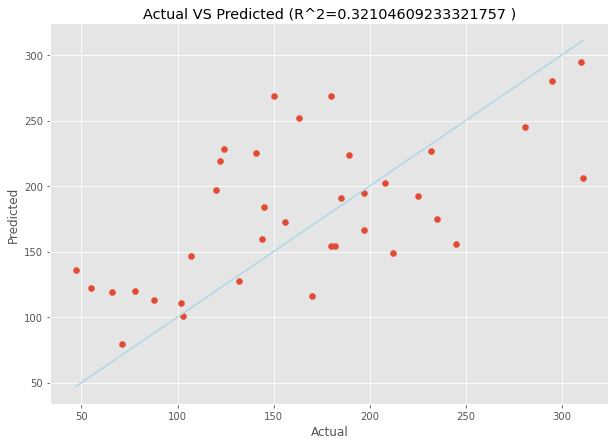

In [26]:
def train_test_compare_register(ws,target_column_name,esml_modelname,esml_model_alias, esml_current_env, train_ds,validate_ds,test_ds):
    test_scoring = None # IESMLTestScoringFactory
    comparer = None # IESMLModelCompare
    trainer = None # IESMLTrainer

    # CUSTOMIZE ############### Optinonal: You can CUSTOMIZE, by implementing your own CLASS that supports interfaces/abstract classes: IESMLTestScoringFactory,IESMLModelCompare
    ml_type = "regression"
    test_scoring = ESMLTestScoringFactory(ml_type) # You need to implement IESMLTestScoringFactory
    comparer = ESMLModelCompare(setting_path = "") # You need to implement IESMLModelCompare
    # CUSTOMIZE END ###############

    secret_name_tenant = "kv-msft-weu-dev-cmnai-tenant"
    secret_name_sp_id = "kv-secret-esml-project002-sp-id"
    secret_name_sp_secret = "kv-secret-esml-project002-sp-secret"

    controller = ESMLController(comparer,test_scoring,"project002",esml_modelname, esml_model_alias, secret_name_tenant,secret_name_sp_id,secret_name_sp_secret) # IESMLController: you do not have to change/implemen this class. Dependency injects default or your class.
    controller.dev_test_prod = esml_current_env

    ##1 ) Get "current" 'last_gold_training_run' [pipeline_run_id, training_data_used]

    experiment, model,main_run, best_automl_run,fitted_model_1 = IESMLController.get_best_model_run_fitted_model_Dev(ws,controller.experiment_name)

    # ITrainer: Defaults to using AutoML. Optionally you can implement this. Else you need to implement ITrainer in 'YourTrainer' class
    trainer = Trainer(model.name,esml_modelname,esml_model_alias, esml_current_env, ml_type,train_ds,validate_ds,test_ds)
    train_run, aml_model,fitted_model_2 = trainer.train(train_ds,validate_ds)
    
    #  label,ws, GoldTest, model, fitted_model, source_best_run/run
    rmse, r2, mean_abs_percent_error,mae,spearman_correlation,plt, dummy = test_scoring.get_test_scoring_8(ws,target_column_name,test_ds,fitted_model_1,best_automl_run,model)

    next_environment = controller.get_next_environment()

    #  current_ws,current_environment, target_environment,target_workspace, experiment_name)
    target_ws = controller.get_target_workspace(current_environment = esml_current_env, current_ws = ws, target_environment = esml_current_env)

    ## 2) COMPARE if better

    promote_new_model,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = comparer.compare_scoring_current_vs_new_model(
        new_run_id = main_run.id,
        current_ws = ws,
        current_environment = esml_current_env,
        target_environment = esml_current_env,
        target_workspace = target_ws,
        experiment_name = trainer.experiment_name)


    print("compared once, 1 time, inner loop - Dev")

    ## 3) REGISTER model, if better

    if (promote_new_model == True): # Better than all in DEV?! (Dev or Test,  is usually current_env)
        model_registered_in_target = controller.register_model(source_ws=ws, target_env=esml_current_env, source_model_to_copy_tags_from=model)
        print("registered in DEV")

        # Better than all in DEV, Lets check if its better than all in TEST? (or prod)
        next_environment = controller.get_next_environment() # Test, or PROD
        promote_new_model,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = comparer.compare_scoring_current_vs_new_model(
            new_run_id = main_run.id,
            current_ws = ws,
            current_environment = esml_current_env,
            target_environment = next_environment,
            target_workspace = target_ws,
            experiment_name = trainer.experiment_name)

        print("Compared 2nd time - Outer loop")
        if (promote_new_model == True):
            model_registered_in_target = controller.register_model(source_ws=ws, target_env="test", source_model_to_copy_tags_from=model)
            print("Registered in TEST")

train_test_compare_register(ws,target_column_name,esml_modelname,esml_model_alias, esml_current_env, train_ds,validate_ds,test_ds)

# DATASET: See Run info from last gold scored

In [27]:
from azureml.core.dataset import Dataset
# p = ESMLProject()
# ...
# ...p.connect_to_lake()
meta_dataset = Dataset.get_by_name(p.ws, name="M10_GOLD_SCORED_RUNINFO")
meta_dataset.to_pandas_dataframe()

,pipeline_run_id,scored_gold_path,date_in_parameter,date_at_pipeline_run,model_version
0,2187a2e5-6771-47a9-8d3f-aa72715b6088,projects/project002/10_titanic_model_clas/infe...,2021-01-01 10:35:01.243860,2021-12-09 22:40:18.260194,1
